 # 전통적 시계열 모델링

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성 

* 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

* 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

## (3) 데이터 불러오기

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path, usecols = ['date', 'sales'])
data = data.loc[data['date']<= '2014-10-31'].reset_index(drop = True)
data['date'] = pd.to_datetime(data['date'])
data['weekday'] = data['date'].dt.day_name().str.slice(0,3)
data.head()

,date,sales,weekday
0,2013-01-01,45,Tue
1,2013-01-02,53,Wed
2,2013-01-03,65,Thu
3,2013-01-04,66,Fri
4,2013-01-05,97,Sat


* 변수 설명

    * date : 날짜
    * sales : 판매량
    * weekday : 요일

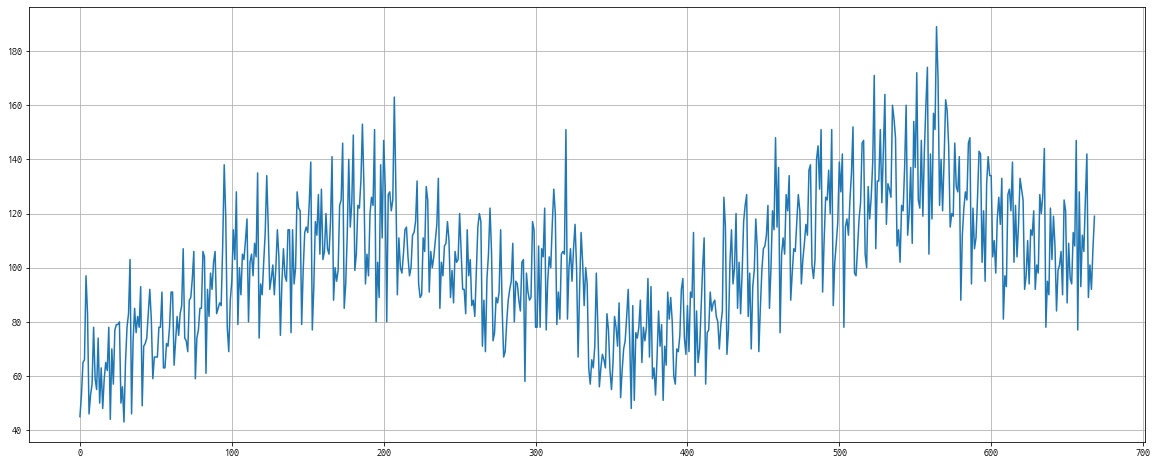

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

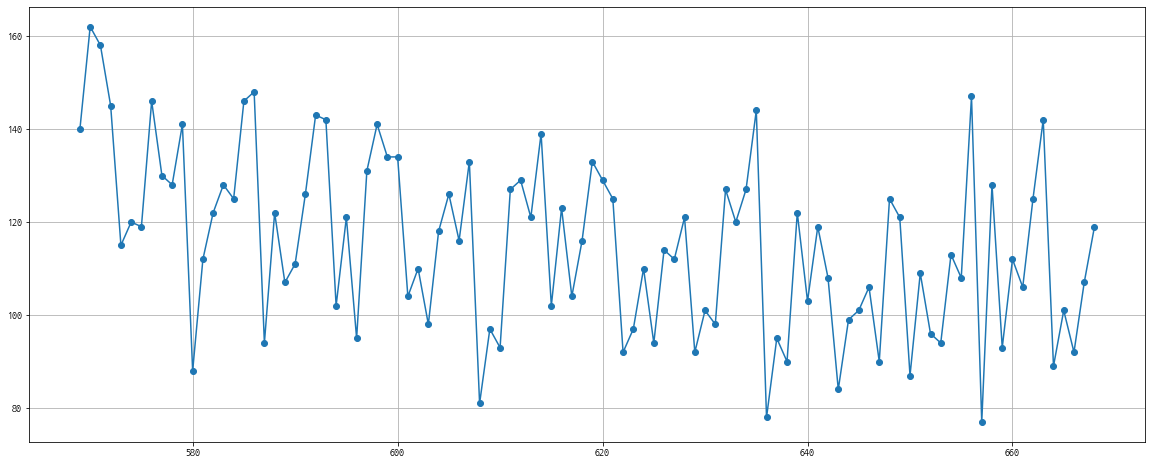

In [6]:
temp = data[-100:]
plt.figure(figsize = (20,8))
plt.plot(temp['sales'], marker ='o')
plt.grid()
plt.show()

# 2.기본 전처리

## (1) y 만들기

* 사전 관찰(look-ahead) : 미래의 어떤 사실을 안다는 뜻
* 사전 관찰 문제 : 
    * 데이터를 통해 실제로 알아야 하는 시점보다 더 일찍 미래에 대한 사실을 알게 되는 문제.  
    * 사전관찰 문제가 있는 채로 모델링을 하게 되면, 놀라운 성능의 모델이 만들어짐. --> 그러나 실제로는 불가능한 상황.

* 그래서 y를 만들때 사전관찰문제가 발생되지 않도록 해야 함.
    * 예제는 1일 후의 수요량을 예측하려고 합니다.

* 1일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [7]:
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,sales,weekday,y
0,2013-01-01,45,Tue,53.0
1,2013-01-02,53,Wed,65.0
2,2013-01-03,65,Thu,66.0
3,2013-01-04,66,Fri,97.0
4,2013-01-05,97,Sat,83.0


,date,sales,weekday,y
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0
668,2014-10-31,119,Fri,NaN


In [8]:
# 제일 마지막 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,sales,weekday,y
663,2014-10-26,142,Sun,89.0
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0


## (2) 데이터 분할

### 1) x, y 나누기

In [9]:
target = 'y'

x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* 1회 분할 : train_test_split( x, y, test_size= , shuffle = False) 
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기
* k-fold cross validation for Time Seires : TimeSeriesSplit

In [10]:
# 여기서는 1회 분할로 진행합니다.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

# 3.모델링1 : ARIMA

## (1) y 값 살펴보기

* 정규성 검정(> 0.05) :  0.00853
* 정상성 검정(< 0.05) :  0.27897
* 자기상관성 확인(ACF, PACF)


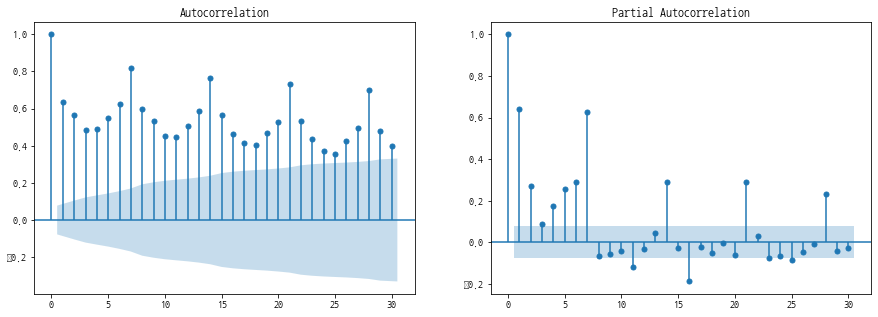

In [11]:
residual_diag(y_train, lags = 30)

## (2) 모델링 : 초기모델

* p, d, q 값을 어떻게 정해야 할까요?
* AR의 p 차수와 MA q 차수 모두 값이 필요해 보입니다. 일단 1, 1을 지정합시다.

### 1) 학습

* sm.tsa.SARIMAX(train, order=(p,d,q)).fit()
    * 모델 선언시 train이 포함
    * .fit()으로 학습.

In [12]:
# ARIMA 모델링
m1_1 = sm.tsa.SARIMAX(y_train, order=(1,0,1)).fit() # order = AR + MA
m1_2 = sm.tsa.SARIMAX(y_train, order=(1,1,1)).fit() # order = AR + I + MA

### 2) 평가

#### ① 잔차진단

* 모델.resid : 잔차를 뽑을 수 있습니다.
* 위에서 만든 함수 residual_diag 를 사용하여 잔차진단을 해 봅시다.

* 정규성 검정(> 0.05) :  0.38791
* 정상성 검정(< 0.05) :  0.00088
* 자기상관성 확인(ACF, PACF)


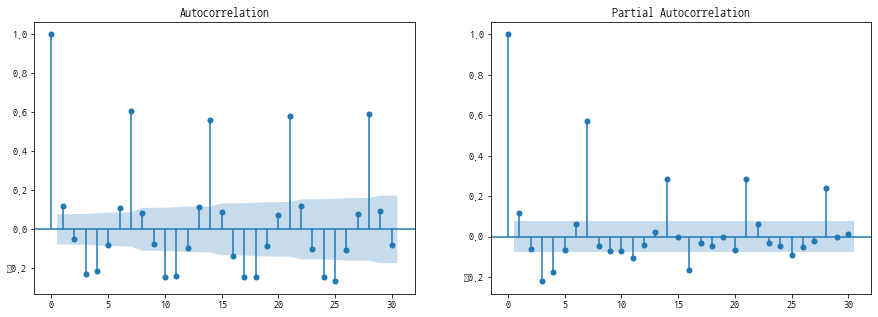

In [13]:
residuals = m1_1.resid
residual_diag(residuals)

* 정규성 검정(> 0.05) :  0.07599
* 정상성 검정(< 0.05) :  0.00115
* 자기상관성 확인(ACF, PACF)


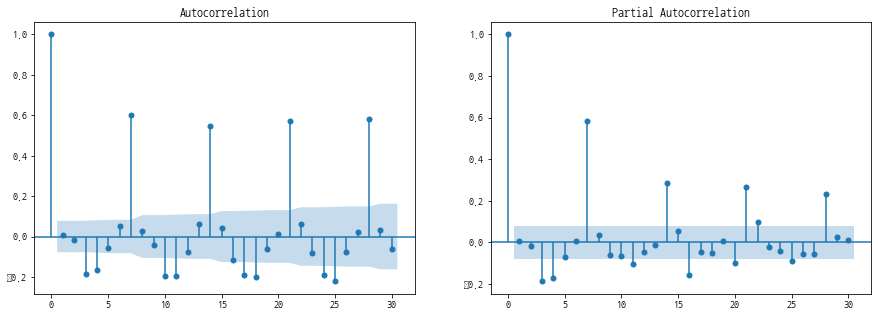

In [14]:
residuals = m1_2.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수
* SARIMAX 모델.aic로 쉽게 통계량을 구할 수 있습니다.

In [15]:
print('model1 AIC :', m1_1.aic)
print('model2 AIC :', m1_2.aic)

model1 AIC : 5464.670363960708
model2 AIC : 5442.769868773823


#### ③ Validation

시계열 데이터로 실제값과 예측값에 대해 비교하여 그래프를 그려봅시다.

In [18]:
pred = m1_1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 12.918460959652306
MAPE: 0.12228691428354797


In [19]:
pred = m1_2.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 13.123421572150058
MAPE: 0.12539084122967378


* 결과 시각화

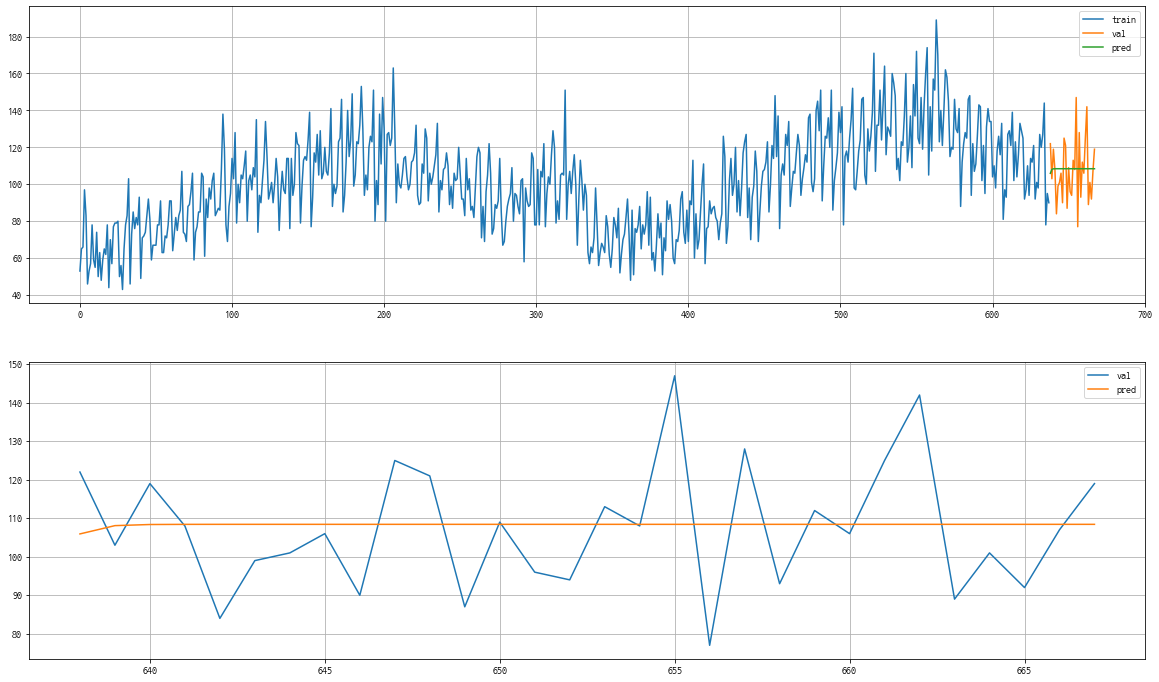

In [20]:
plot_model_result(y_train, y_val, pred)

## (3) 하이퍼파라미터 튜닝

실제로 p, d, q를 찾는 과정은 마치 Grid Search 처럼 값을 조금씩 조정해가며  최적의 모델을 찾아가는 과정과 유사합니다.


### 1) 학습

In [21]:
from itertools import product

* 값의 범위 지정

In [22]:
# product 함수를 이용하여 값의 조합을 구성
p = [1,2,3,4]
q = [1,2,3,4]
d = [1]
iter = list(product(p,d,q))
iter

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4)]

* 튜닝

In [23]:
# 
mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)


In [24]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
11,"(3, 1, 4)",11.057151,5219.319721


,"params(p,d,q)",mae,aic
10,"(3, 1, 3)",11.5905,5171.92015


In [25]:
m1_3 = sm.tsa.SARIMAX(y_train, order=(3,1,3)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.00652
* 정상성 검정(< 0.05) :  4e-05
* 자기상관성 확인(ACF, PACF)


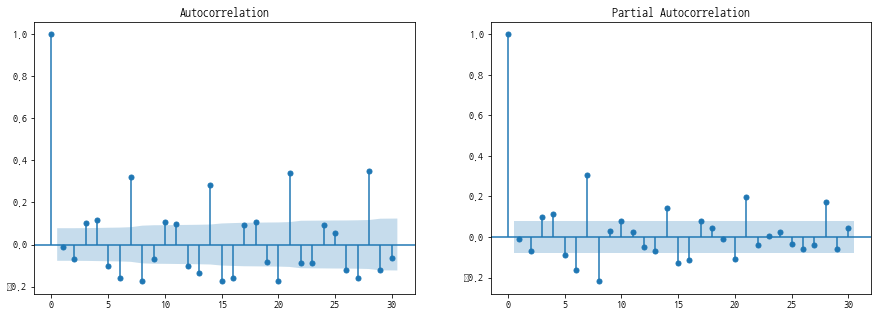

In [26]:
residuals = m1_3.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [27]:
print('model2 AIC :', m1_3.aic)

model2 AIC : 5171.9201501481175


#### ③ Validation

In [28]:
pred = m1_3.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 11.590500479029398
MAPE: 0.11049384327992426


* 결과 시각화

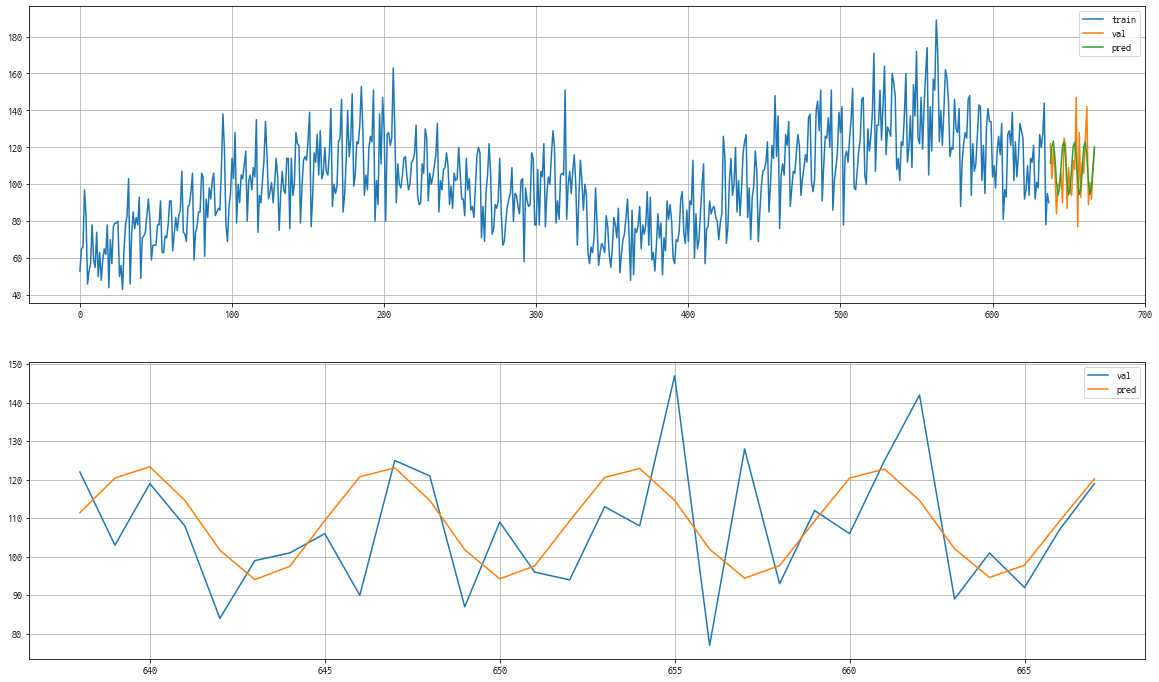

In [29]:
plot_model_result(y_train, y_val, pred)

# 4.모델링2 : SARIMA

## (1) 모델링 : 초기모델

### 1) 학습

In [30]:
# SARIMA 모델링
m2_1 = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(1,1,1,7)).fit()

### 2) 평가

#### ① 잔차진단

* 정규성 검정(> 0.05) :  0.00274
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


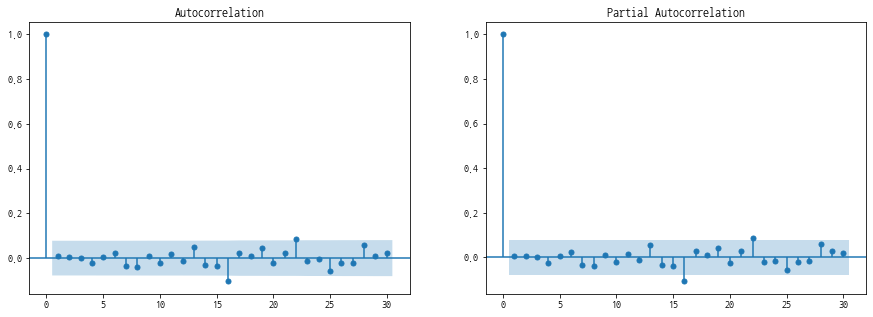

In [31]:
residuals = m2_1.resid
residual_diag(residuals)

#### ② AIC

In [33]:
print('model2_0 AIC :', m2_1.aic)

model2_0 AIC : 4846.302440142703


#### ③ Validation

In [34]:
pred = m2_1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 7.942958528277967
MAPE: 0.0733998184034363


* 결과 시각화

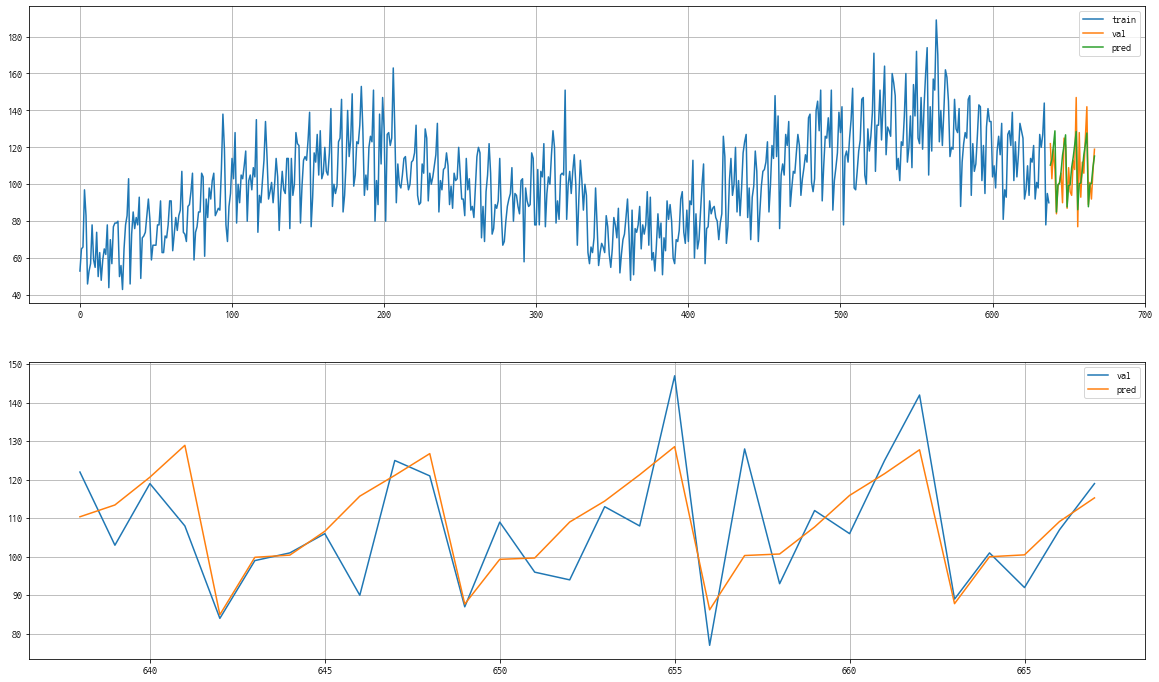

In [35]:
plot_model_result(y_train, y_val, pred)

## (2) 하이퍼파라미터 튜닝
2~4분 걸립니다. 돌려 놓고 쉬는시간 갖겠습니다.

### 1) 학습

In [36]:
P = [1,2,3]
Q = [1,2,3]
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q))

for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(i[0],i[1],i[2],7)).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


In [37]:
result = pd.DataFrame({'params(P,D,Q)' : iter, 'mae' : mae, 'aic':aic})

result

,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",7.942959,4846.302440
1,"(1, 1, 2)",8.114581,4848.938479
2,"(1, 1, 3)",8.142838,4850.569859
3,"(2, 1, 1)",8.154073,4848.678504
4,"(2, 1, 2)",8.082112,4850.597854
5,"(2, 1, 3)",8.051298,4848.928107
6,"(3, 1, 1)",7.934638,4849.688099
7,"(3, 1, 2)",8.018790,4852.042344
8,"(3, 1, 3)",8.094449,4853.143671


In [38]:
display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(P,D,Q)",mae,aic
6,"(3, 1, 1)",7.934638,4849.688099


,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",7.942959,4846.30244


In [41]:
# MAE와 AIC 가 제일 낮은 값들로 모델을 각각 생성해 봅시다.
m2_2 = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(3, 1, 1, 7)).fit()
m2_3 = sm.tsa.SARIMAX(y_train, order=(3,1,3), seasonal_order=(1, 1, 1, 7)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.00259
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


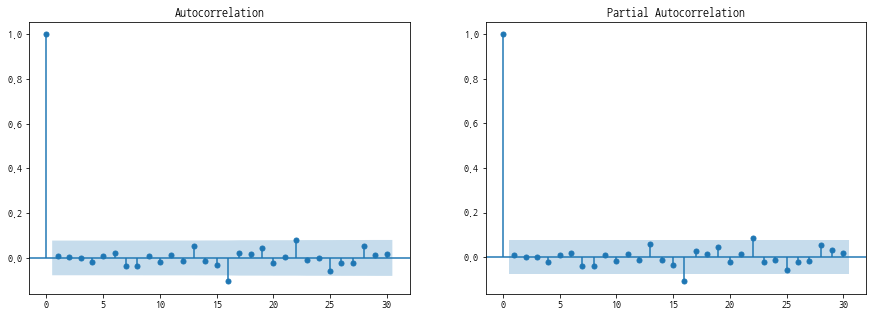

In [42]:
residuals = m2_2.resid
residual_diag(residuals)

* 정규성 검정(> 0.05) :  0.00274
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


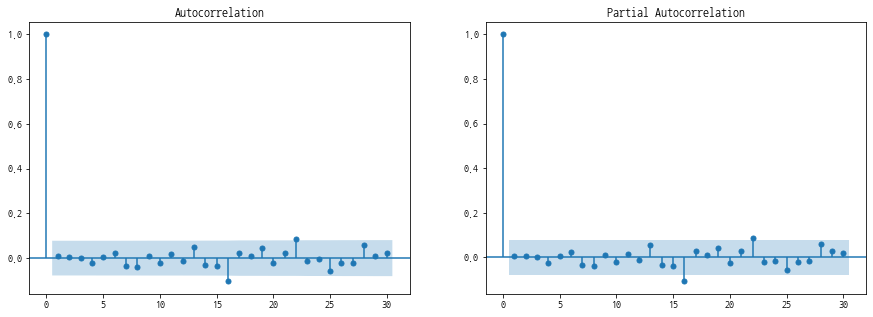

In [43]:
residuals = m2_3.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [44]:
print('model2_2 AIC :', m2_2.aic)
print('model2_3 AIC :', m2_3.aic)

model2_2 AIC : 4849.688098643057
model2_3 AIC : 4846.302440142703


#### ③ Validation

In [45]:
pred = m2_3.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 7.942958528277967
MAPE: 0.0733998184034363


* 결과 시각화

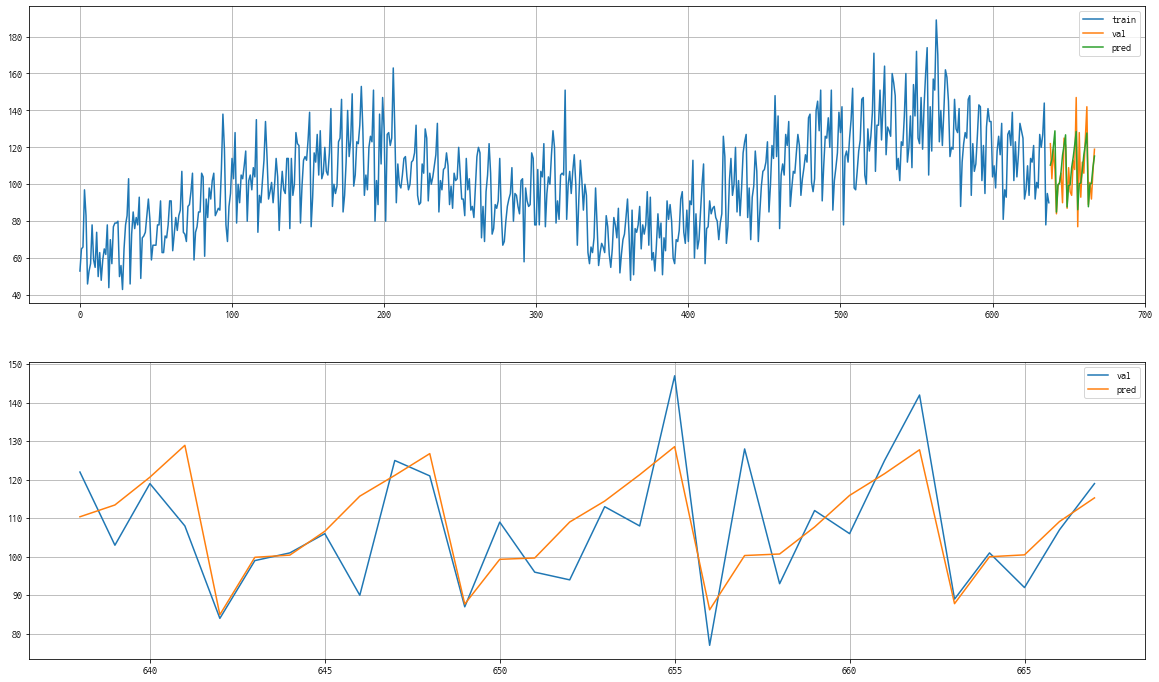

In [46]:
plot_model_result(y_train, y_val, pred)

# 5.모델링3 : SARIMAX

## (1) 전처리

In [ ]:
# 가변수화
x2 = pd.get_dummies(x, columns = ['weekday'], drop_first=False)

# feature engineering
x2['sales_lag7'] = x2['sales'].shift(6)
x2.head(10)


In [ ]:
x3, y3 = x2[6:].copy(), y[6:].copy()

x3.reset_index(drop = True, inplace = True)
y3.reset_index(drop = True, inplace = True)
x3.head()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 30, shuffle = False)

## (1) 모델링

### 1) 학습
* 학습할 때 **exog=x_train** 옵션이 포함되어야 함.

In [ ]:
m3_1 = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(1,1,1,7), exog=x_train).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

In [ ]:
residuals = m3_1.resid
residual_diag(residuals)

#### ② AIC

In [ ]:
print('m3_1 AIC :', m3_1.aic)

#### ③ Validation
SARIMAX 모델을 생성하고, 예측할 때는 **exog=x_val** 옵션이 들어가야 함.

In [ ]:
pred = m3_1.forecast(30,  exog=x_val)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

* 결과 시각화

In [ ]:
plot_model_result(y_train, y_val, pred)